# Physics-Informed Neural Network

Идея заключается в том, что в **Loss function** добавляется дифференциальное уравнение.
Система уравнения Лоренца (аттрактор Лоренца): <br>
$\dot{x} = \textbf{s} (x - y)$ <br>
$\dot{y} = x (\textbf{r} - z) - y$ <br>
$\dot{z} = xy - \textbf{b}z$ <br>


Есть 2 варианта решения:
1. Простая регрессионная модель. Предположим, что знаем порядок дифф. уравнения (первый порядок), но вид правой части неизвестен. Правая часть оттыскивается через взятие производной от обученной модели: <br>
$\dot{x} = \dot{f_x}(x, y, z)$ <br>
$\dot{y} = \dot{f_y}(x, y, z)$ <br>
$\dot{z} = \dot{f_z}(x, y, z)$ <br>
2. Регрессионная модель с *известной* введенной физикой. Предположим, что мы знаем вид уравнения, т.е. знаем вид правой части, но хотим найти неизвестные коэффициенты в правой части $(\textbf{s}, \textbf{r}, \textbf{b})$
3. Регрессионная модель с *неизвестной* введенной физикой. Порядок уравнения *известен*, но вид правой части неизвестен. Правая часть представляется полиномами с неизвестными коэффициентами.
4. Регрессионная модель с *неизвестной* введенной физикой. Порядок уравнения *неизвестен*, но вид правой части неизвестен. Правая часть представляется полиномами с неизвестными коэффициентами.

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm.notebook import tqdm

In [ ]:
def lorenz(x, y, z, s=10.0, r=28.0, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    dx = s*(y - x)
    dy = r*x - y - x*z
    dz = x*y - b*z
    return dx, dy, dz

In [ ]:
N / 3

16667.0

In [ ]:
N = 50001
n = N//3
N += n
dt = 0.001
t = np.arange(0, dt * N, dt)

xs, ys, zs = np.empty((3, N))
dx, dy, dz = np.empty((3, N))
xs[0], ys[0], zs[0] = (0., 1., 1.05)

for i in tqdm(range(N - 1)):
    dx[i], dy[i], dz[i] = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (dx[i] * dt)
    ys[i + 1] = ys[i] + (dy[i] * dt)
    zs[i + 1] = zs[i] + (dz[i] * dt)
  
dx[-1], dy[-1], dz[-1] = lorenz(xs[-1], ys[-1], zs[-1])

In [ ]:
f = np.linspace(0, 1/dt/2, len(t)//2)
w = 2 * np.pi * f

Xf, Yf, Zf = [np.abs(np.fft.fft(xi))[:len(xi)//2] for xi in [xs,ys,zs]]
f_ = (Xf > Xf.max() * 0.1) * f

In [ ]:
sp = 10 # sparse parameter for data that are to be trained
x_extr, y_extr = t, np.array([xs, ys, zs]).T
x_test, y_test = x_extr[:N-n], y_extr[:N-n]

x_train = x_test[::sp]
y_train = y_test[::sp]

In [ ]:
dy_extr = np.array([dx, dy, dz]).T
dy_test = dy_extr[:N-n]

In [ ]:
Tanh = L.Lambda(lambda x: tf.math.tanh(x))
iDense = L.Lambda(lambda x: (1.0 - x[0]) * x[1] + x[0] * x[2], name='iDense') # [Z, U, V]

class AdaptTanh(L.Layer):
    def __init__(self, n, **kwargs):
        super(AdaptTanh, self).__init__(**kwargs)
        self.n = n
        self.a = self.add_weight(name='a', 
                                 shape=(1,),
                                 initializer='ones',
                                 trainable=True) 
    def call(self, X):
        return tf.math.tanh(self.n * self.a * X)
    
class Sine(L.Layer):
    def __init__(self, **kwargs):
        super(Sine, self).__init__(**kwargs)

    def call(self, X):
        return tf.math.sin(X)

def initer(w0, wn): 
    def kernel_init(shape, dtype=None):
        n1, n2 = shape
        return tf.linspace([w0]*n1, [wn]*n1, n2, axis=1)
    return kernel_init

class Weight(L.Layer):
    def __init__(self, **kwargs):
        super(Weight, self).__init__(**kwargs)
        self.w = self.add_weight(name='w', 
                                 shape=(1,),
                                 initializer='he_normal',
                                 trainable=True)
    def call(self, x):
        return tf.ones_like(x) * self.w

In [ ]:
Diff = L.Lambda(lambda x: tf.gradients(x[0], x[1])[0])

def Lorenz(nl=3, nu=100, indim=1, outdim=3, UV=False, act=Sine(), 
           resnet=False, w_initializer=None, regularizer=None, 
           a_initializer=None, params=None):
    
    t = L.Input((indim,), name='t')

    outs = []
    for k in range(outdim):
        x = L.Dense(nu, activation=act, kernel_initializer=w_initializer, 
                    kernel_regularizer=regularizer)(t)
        for i in range(nl - 1):
            y = L.Dense(nu, activation=act, kernel_initializer=w_initializer, 
                        kernel_regularizer=regularizer)(x)
            x = y
        X = L.Dense(1, activation='linear', kernel_initializer=a_initializer)(x)
        outs.append(X)
    
    if len(outs) > 1: Y = L.Concatenate()(outs)
    else: Y = outs
    Ym = Model(inputs=t, outputs=Y)
    
    if isinstance(params, type(None)):
        kw = ['s', 'r', 'b']
        s, r, b = [Weight(name=kwi)(xi) for xi, kwi in zip(outs, kw)]
    else: 
        s, r, b = params
        
    dx = L.Lambda(lambda x: x[2] * (x[1] - x[0]))(outs[:2] + [s])
    dy = L.Lambda(lambda x: x[0] * (x[3] - x[2]) - x[1])(outs + [r])
    dz = L.Lambda(lambda x: x[0] * x[1] - x[3] * x[2])(outs + [b])
    
    dY = [Diff([yi, t]) for yi in outs]
    D = [dx, dy, dz]
    LdY = [L.Lambda(lambda x: tf.abs(x[1] - x[0]))([yi, xi]) for yi, xi in zip(dY, D)]
    LdY = L.Concatenate()(LdY)
    
    if len(outs) > 1: dY = L.Concatenate()(dY)
    dYm = Model(inputs=t, outputs=dY)
    Lm = Model(inputs=t, outputs=[Y, LdY])
    
    return Ym, dYm, Lm

In [ ]:
freq_init = initer(0.0, 30.0)
ampl_init = 'ones'
reg = regularizers.l1(0.01)

Y, dY, M = Lorenz(nl=1, nu=1000, indim=1, outdim=3, UV=False, act=Sine(), 
                w_initializer=freq_init, regularizer=reg, a_initializer=ampl_init, 
                params=[10.0, 28.0, 2.667])

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-4)
M.compile(optimizer=adam, loss='mse', loss_weights=[1.0, 0.1])
Y.compile(optimizer=adam, loss='mse')

In [ ]:
h = Y.fit(x=x_train, y=y_train, 
            epochs=5000, 
            verbose=2,
            batch_size=512,)

In [ ]:
h = M.fit(x=x_train, y=[y_train, np.zeros_like(y_train)], 
            epochs=5000, 
            verbose=2, 
            batch_size=512,)

In [ ]:
y_pred = Y.predict(x_test)
rmae = abs(y_pred - y_test).mean() / abs(y_test).mean() * 100
rmae

4.116639237637918

In [ ]:
y_predx = Y.predict(x_extr)
rmae = abs(y_predx - y_extr).mean() / abs(y_extr).mean() * 100
rmae

33.160272532398984

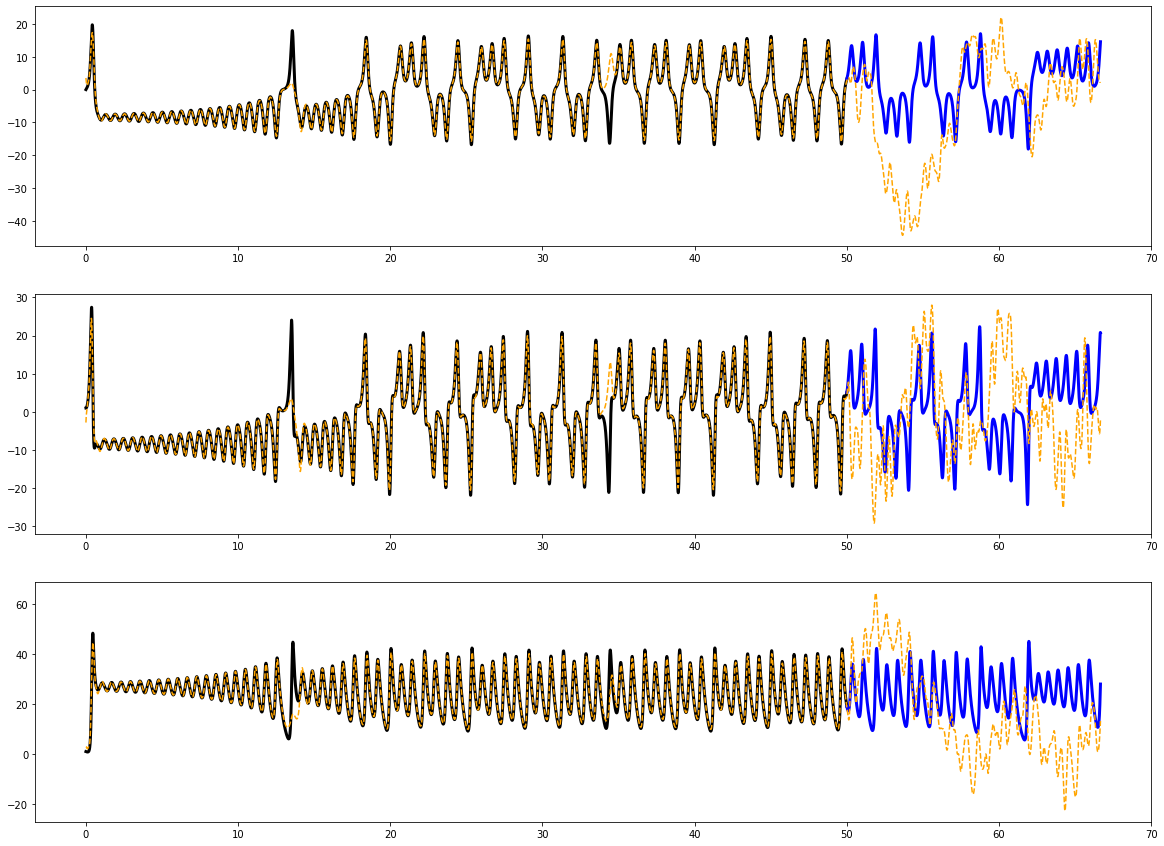

In [ ]:
plt.figure(figsize=(20,15))
for i in range(3):
    plt.subplot(3,1, i+1)
    plt.plot(x_test, y_test[:,i], lw=3, c='k')
    plt.plot(x_extr[N-n:], y_extr[N-n:,i], lw=3, c='b')
    plt.plot(x_extr, y_predx[:,i], ls='--', c='orange')

In [ ]:
dy_pred = dY.predict(x_test)
rmae = abs(dy_pred - dy_test).mean() / abs(dy_test).mean() * 100
rmae

14.773270503682944

In [ ]:
dy_predx = dY.predict(x_extr)
rmae = abs(dy_predx - dy_extr).mean() / abs(dy_extr).mean() * 100
rmae

46.9548620200438

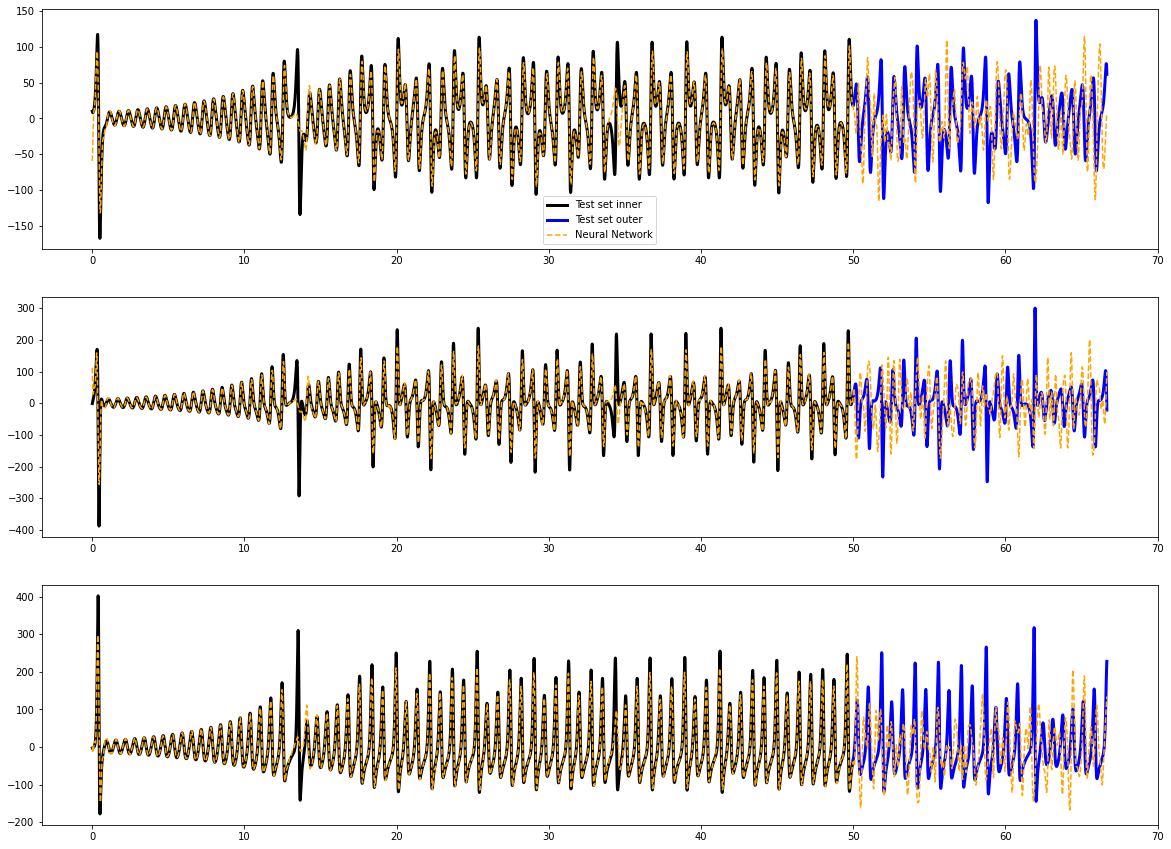

In [ ]:
plt.figure(figsize=(20,15))
for i in range(3):
    plt.subplot(3,1, i+1)
    plt.plot(x_test, dy_test[:,i], lw=3, c='k', label='Test set inner')
    plt.plot(x_extr[N-n:], dy_extr[N-n:,i], lw=3, c='b', label='Test set outer')
    plt.plot(x_extr, dy_predx[:,i], ls='--', c='orange', label='Neural Network')
    if i == 0:
      plt.legend(loc='best')

In [ ]:
for i in range(3):
  print(M.layers[7:10][i].weights)

[]
[]
[]


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=xs[::5], y=ys[::5], z=zs[::5], opacity=0.85,
                             name='original', mode='lines', line=dict(width=1)))
fig.add_trace(go.Scatter3d(x=y_extr[N-n:][::5,0], y=y_extr[N-n:][::5,1], z=y_extr[N-n:][::5,2], opacity=0.85,
                             name='original_extra', mode='lines', line=dict(width=1)))
fig.add_trace(go.Scatter3d(x=y_predx[::5, 0], y=y_predx[::5, 1], z=y_predx[::5, 2], opacity=0.85,
                             name='neural network', mode='lines', line=dict(width=1)))
fig.update_layout(margin=dict(b=0, l=0, r=0, t=0))
fig.show()

In [ ]:
fig.write_html('Attractor.html')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=dx[::5], y=dy[::5], z=dz[::5], opacity=0.85,
                             name='original', mode='lines', line=dict(width=1)))
fig.add_trace(go.Scatter3d(x=dy_pred[::5, 0], y=dy_pred[::5, 1], z=dy_pred[::5, 2], opacity=0.85,
                             name='neural network', mode='lines', line=dict(width=1)))
fig.update_layout(margin=dict(b=0, l=0, r=0, t=0))
fig.show()

In [ ]:
fig.write_html('dAttractor.html')

In [ ]:
y_pred = Y.predict(x_test)
rmae = abs(y_pred - y_test).mean() / abs(y_test).mean() * 100
rmae